# Early Stage Skin Cancer Detection using Deep Learning
CSE second year mini project by Amrit Anand(2100320100021)

## Import Required Libraries

In [ ]:
# Download from the internet if not already installed
import sys
!{sys.executable} -m pip install numpy > /dev/null
!{sys.executable} -m pip install matplotlib > /dev/null
# download tensorflow-gpu instead if you have a graphics card
# go to: https://www.tensorflow.org/install/gpu
!{sys.executable} -m pip install tensorflow > /dev/null

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.optimizers import Adam
from keras import backend as K
import gc

## Importing and processing our data

In [ ]:
BATCH_SIZE = 64
IMG_SIZE = 224
sigmaX = 10  # standard deviation for Gaussian filter

train_dir = '/content/drive/MyDrive/data/train/'
test_dir = '/content/drive/MyDrive/data/test/'


train_benign_dir = os.path.join(train_dir, 'benign')
train_malignant_dir = os.path.join(train_dir, 'malignant')
test_benign_dir = os.path.join(test_dir, 'benign')
test_malignant_dir = os.path.join(test_dir, 'malignant')


In [ ]:
train_malignant_images = len([entry for entry in os.listdir(train_malignant_dir) if os.path.isfile(os.path.join(train_malignant_dir, entry))])
train_benign_images = len([entry for entry in os.listdir(train_benign_dir) if os.path.isfile(os.path.join(train_benign_dir, entry))])
test_malignant_images = len([entry for entry in os.listdir(test_malignant_dir) if os.path.isfile(os.path.join(test_malignant_dir, entry))])
test_benign_images = len([entry for entry in os.listdir(test_benign_dir) if os.path.isfile(os.path.join(test_benign_dir, entry))])

print("Training images: ", train_malignant_images+train_benign_images)
print("Benign training images:", train_benign_images)
print("Malignant training images:", train_malignant_images)
print("Testing images:", test_benign_images+test_malignant_images)
print("Benign testing images:",test_benign_images)
print("Malignant testing images",test_malignant_images)

Training images:  2637
Benign training images: 1440
Malignant training images: 1197
Testing images: 660
Benign testing images: 360
Malignant testing images 300


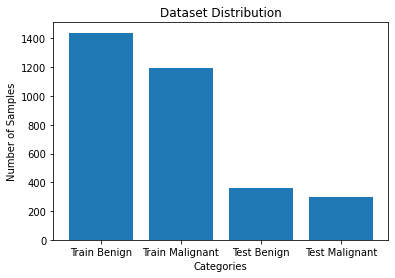

In [ ]:
categories = ['Train Benign', 'Train Malignant', 'Test Benign', 'Test Malignant']
counts = [train_benign_images, train_malignant_images, test_benign_images, test_malignant_images]

plt.bar(categories, counts)
plt.title('Dataset Distribution')
plt.xlabel('Categories')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
train_image_generator = ImageDataGenerator(
                                           rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.4,
      brightness_range=[0.4,1.5])
test_image_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.4,
      brightness_range=[0.4,1.5])

train_data_gen = train_image_generator.flow_from_directory(batch_size=32,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(224, 224),
                                                           class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(batch_size=32,
                                                         directory=test_dir,
                                                         target_size=(224, 224),
                                                         class_mode='binary')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [ ]:
train_data_gen.image_shape

(224, 224, 3)

### Showcase of some images

In [ ]:
def plot_images(img_arr):
    fig, axes = plt.subplots(1, 5, figsize=(25, 25))
    axes = axes.flatten()
    for img, ax in zip(img_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

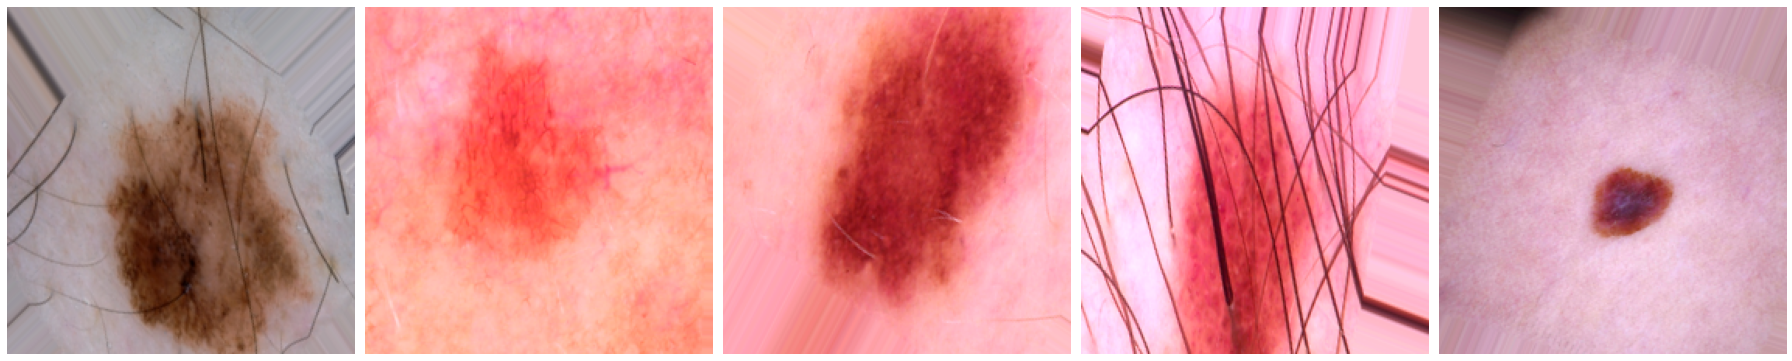

In [ ]:
sample_training_images, _ = next(train_data_gen)

plot_images(sample_training_images[:5])

## Base Mode

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 64)      9280      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 26, 26, 64)      

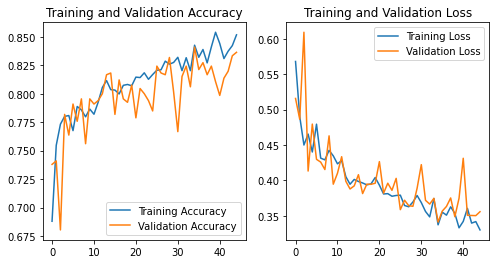

In [ ]:
model = Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dropout(.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss=losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(train_data_gen, epochs=100, batch_size=32, validation_data=test_data_gen, callbacks=[early_stopping])


plot_result()



# Pre-Trained VGG16 model

Epoch 1/100
83/83 [==============================] - 58s 653ms/step - loss: 0.4977 - accuracy: 0.7679 - val_loss: 0.5025 - val_accuracy: 0.7667
Epoch 2/100
83/83 [==============================] - 63s 760ms/step - loss: 0.4340 - accuracy: 0.8032 - val_loss: 0.8254 - val_accuracy: 0.6591
Epoch 3/100
83/83 [==============================] - 54s 653ms/step - loss: 0.4033 - accuracy: 0.8225 - val_loss: 0.4306 - val_accuracy: 0.8045
Epoch 4/100
83/83 [==============================] - 53s 643ms/step - loss: 0.4105 - accuracy: 0.8180 - val_loss: 0.4700 - val_accuracy: 0.7652
Epoch 5/100
83/83 [==============================] - 54s 647ms/step - loss: 0.3862 - accuracy: 0.8218 - val_loss: 0.4021 - val_accuracy: 0.8227
Epoch 6/100
83/83 [==============================] - 53s 645ms/step - loss: 0.3905 - accuracy: 0.8184 - val_loss: 0.3960 - val_accuracy: 0.7955
Epoch 7/100
83/83 [==============================] - 53s 643ms/step - loss: 0.3891 - accuracy: 0.8263 - val_loss: 0.4241 - val_accuracy:

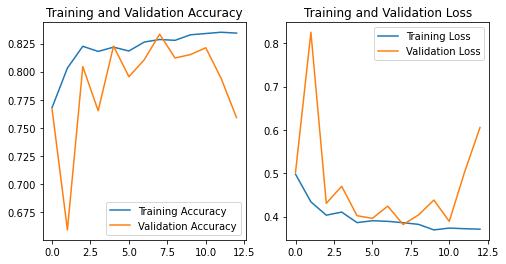

In [ ]:
# Load the pre-trained model VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in vgg_model.layers:
    layer.trainable = False

# Build the model
x = vgg_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=vgg_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(train_data_gen, epochs=100, batch_size=32, validation_data=test_data_gen, callbacks=[early_stopping])

plot_result()


# VGG16 model on top of Base Model

In [ ]:
# Define the base model
base_model = Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(.2),
    layers.Dense(1, activation='sigmoid')
])

# Define the pre-trained VGG16 model
input_tensor = Input(shape=(224, 224, 3))
vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Add the pre-trained model on top of the base model
x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(.2)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=vgg_model.input, outputs=output)

# Freeze the weights of the VGG16 layers
for layer in vgg_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Implement early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Train the model
history = model.fit(train_data_gen, validation_data=test_data_gen, epochs=100, callbacks=[es])
plot_result()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Results

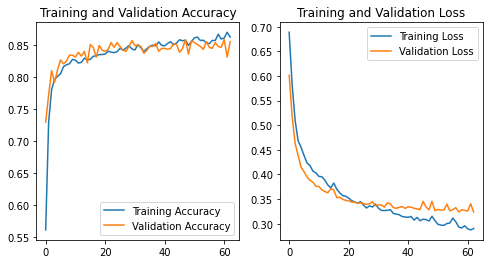

In [ ]:
plot_result()

In [ ]:
def plot_result():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Save Model

In [ ]:
model.save('./models/basic_model.h5')